# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from scipy import stats

# Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [3]:
def cramer_v(x,y):
  cm = pd.crosstab(x,y).values

  n = cm.sum()
  r, k = cm.shape

  chi2 = stats.chi2_contingency(cm)[0]
  chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
  kcorr = k- (k-1)**2/(n-1)
  rcorr = r- (r-1)**2/(n-1)
  return np.sqrt((chi2/n)/(min(kcorr-1,rcorr-1)))

# Load data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df4 = pd.read_csv('/content/drive/MyDrive/health_insurance_cross_sell-main/health_insurance_cross_sell/data/df3.csv')

In [8]:
df4.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,vehicle_age,vehicle_damage,response
0,1,Male,44,28.0,26.0,0,40454.0,217,> 2 Years,1,1
1,2,Male,76,3.0,26.0,0,33536.0,183,1-2 Year,0,0
2,3,Male,47,28.0,26.0,0,38294.0,27,> 2 Years,1,1
3,4,Male,21,11.0,152.0,1,28619.0,203,< 1 Year,0,0
4,5,Female,29,41.0,152.0,1,27496.0,39,< 1 Year,0,0


## Checking dimensions and types

In [9]:
df4.shape

(380297, 11)

In [10]:
df4.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
vehicle_age              object
vehicle_damage            int64
response                  int64
dtype: object

# Exploratory data analysis

## Bivariate analysis

### h1: Clientes com 20 a 30 anos de idade tem um proporção maior de carros com danos

**h1: Customers with age between 20 and 30 have a bigger proportion of cars with damage**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


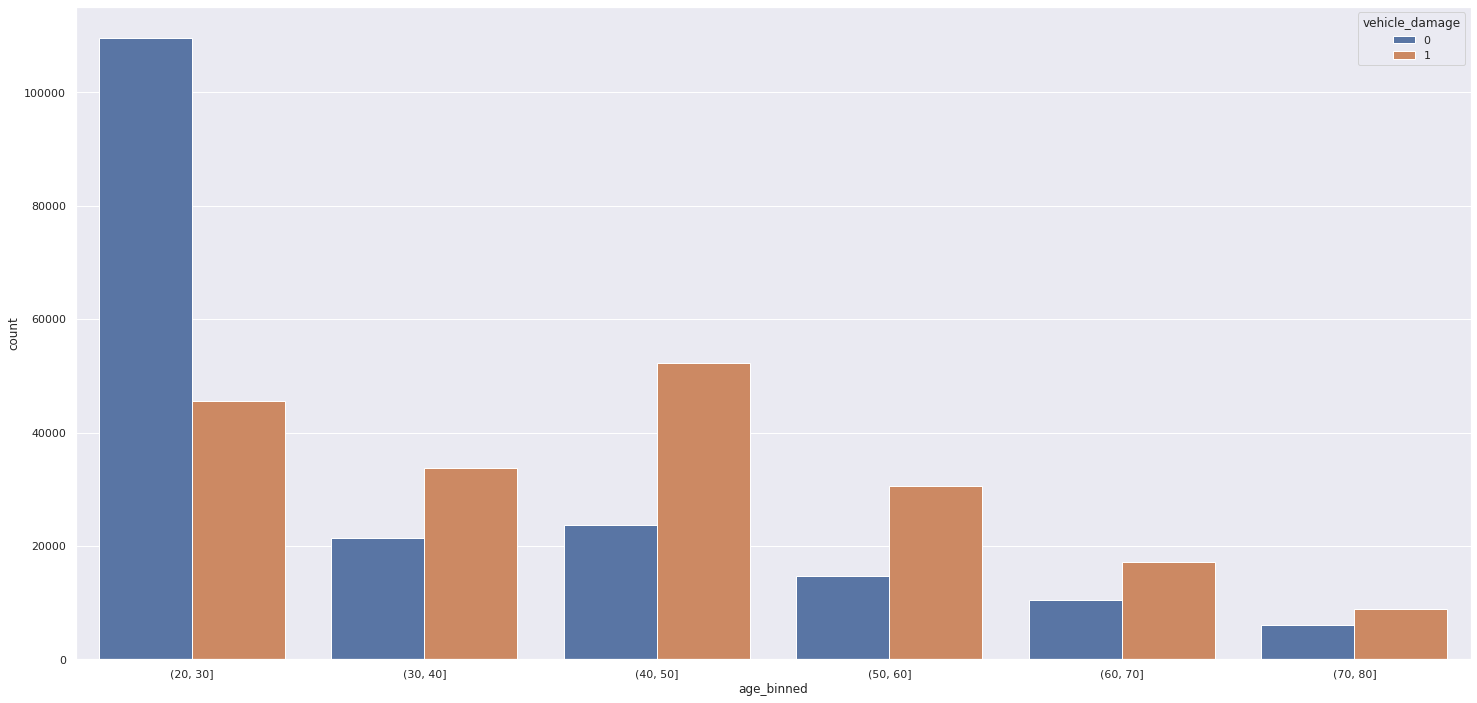

In [11]:
h1 = df4[['age','vehicle_damage']]
bins = list(np.arange(20,86,10))
h1['age_binned'] = pd.cut(h1['age'],bins=bins)
#h1[['age_binned','vehicle_damage']].groupby('age_binned').size()
sns.countplot(x='age_binned',data=h1[['age_binned','vehicle_damage']],hue='vehicle_damage');

Falso, a faixa etária que possuim carros mais danificados é a dos 40 a 50 anos, seguido dos 20 a 30

False, the age group that has most damaged cars is 40 to 50 years old, followed by the 20 to 30

### h2: clientes com mais de 40 anos tendem a já ter seguro veicular

**h2: Customers older than 40 years tend to have a car insurance**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


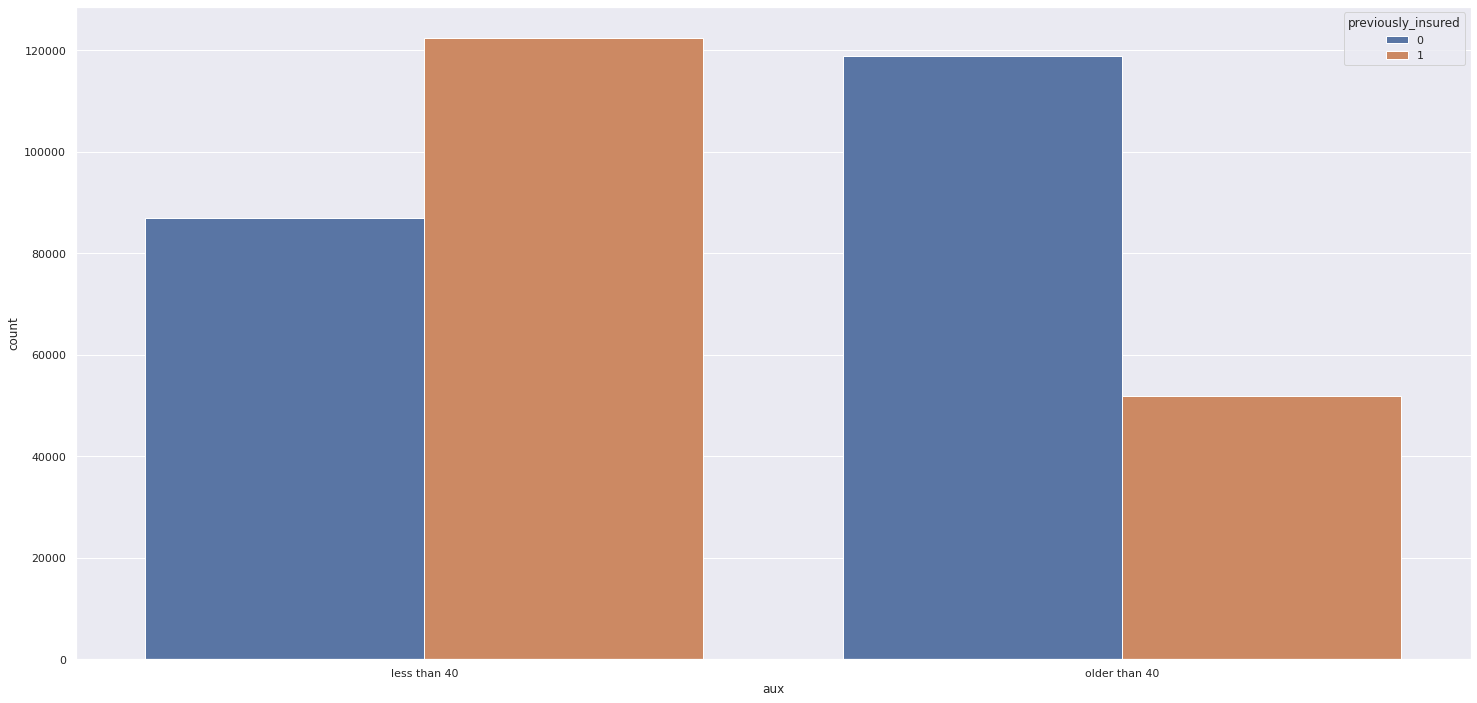

In [12]:
h2= df4[['age','previously_insured']]
h2['aux'] = h2['age'].apply(lambda x: 'older than 40' if x >=40 else 'less than 40')
sns.countplot(x='aux',data=h2,hue='previously_insured',order=['less than 40','older than 40']);

Falso, clientes com mais de 40 anos não possuem uma proporção maior de seguro do que clientes mais novos.

False, customers older than 40 years have no bigger proportion of car insurance than younger customer

### h3: quantos mais velho o cliente mais tendem a responder que sim ao seguro

**h3: The older the customers, the more likely they are to say yes to insurance.**

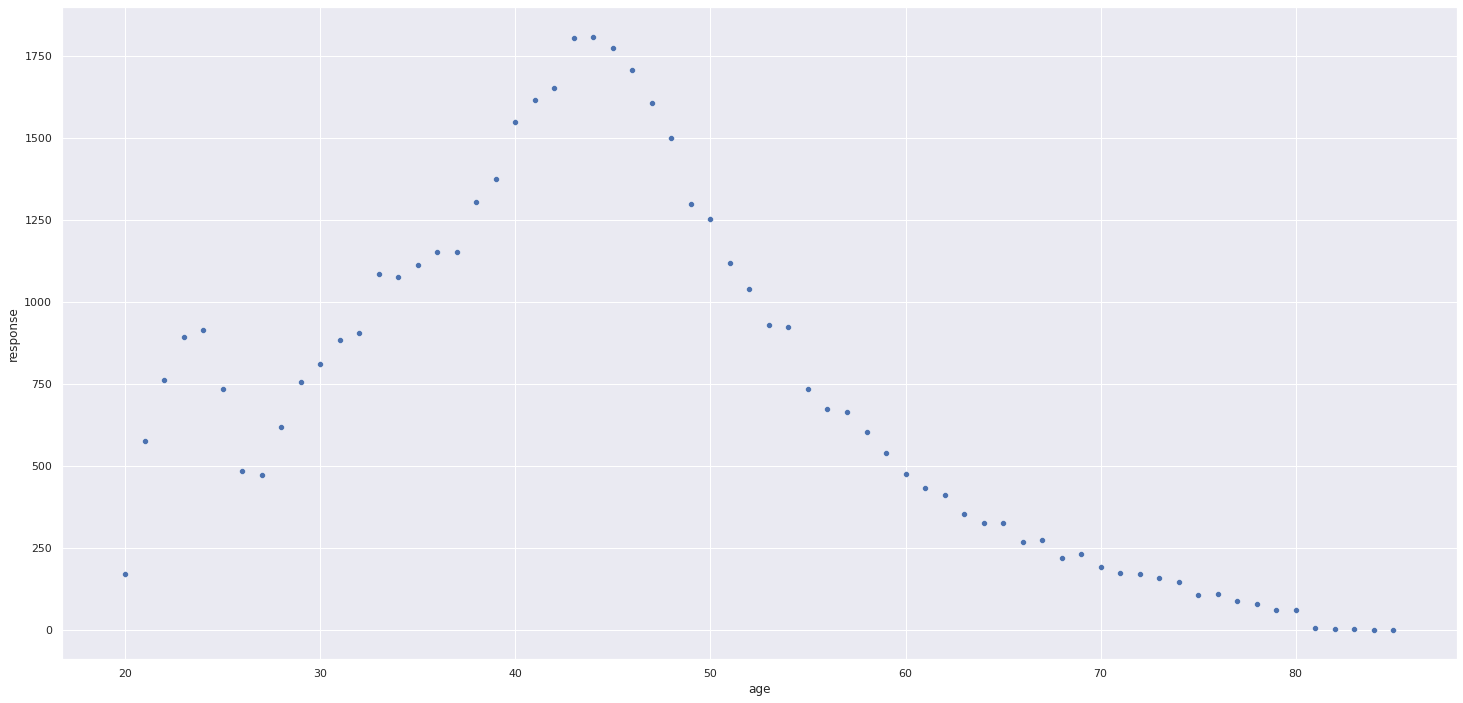

In [13]:
h3 = df4[['age','response']].groupby('age').sum().reset_index()
sns.scatterplot(x='age',y='response',data=h3)

**Falso, ao contrário da proposta quanto mais velho o cliente menos tendência ele apresenta interrese no seguro, boa parte dos que tem interrese estão na faixa dos 30 a 55**

**False, contrary to hypothesis, the older the costumer, less inclined they are to accept insurance, most of interrested customers are between 30 to 55 years olds**

### h4: clientes com mais de 35 anos gastam mais anualmente

**h4: Customers older than 35 years spend more annually with insurance**

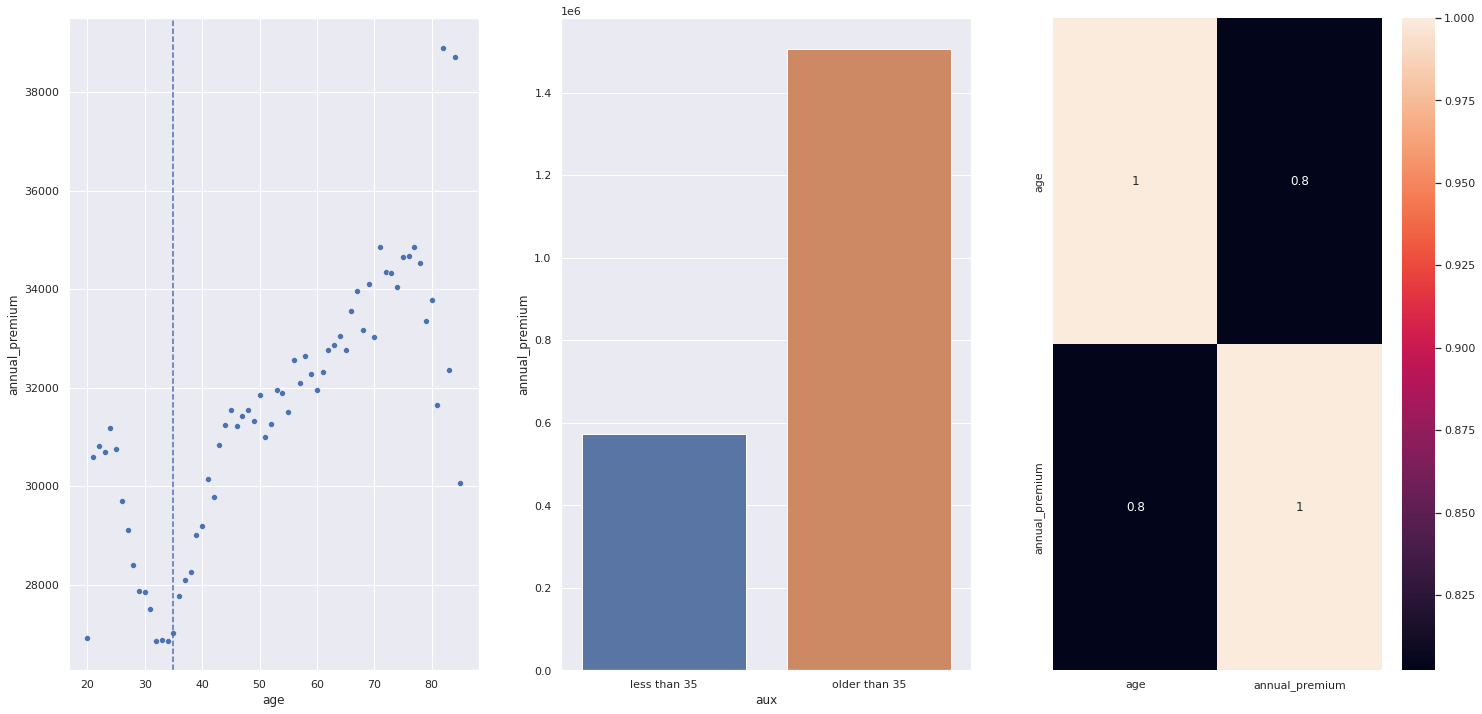

In [14]:
h4 = df4[['age','annual_premium']].groupby('age').mean().reset_index()
h4['aux'] = h4['age'].apply(lambda x: 'older than 35' if x >=40 else 'less than 35')
h4_b = h4[['aux','annual_premium']].groupby('aux').sum().reset_index()
h4_b
plt.subplot(131)
sns.scatterplot(x='age',y='annual_premium',data=h4)
plt.axvline(35,linestyle='--')
plt.subplot(132)
sns.barplot(x='aux',y='annual_premium',data=h4_b)
plt.subplot(133)
sns.heatmap(h4[['age','annual_premium']].corr(method='pearson'),annot=True)

Verdadeiro, Clientes com mais de 35 anos apresentam têndencia e montante total de gastos maiores do que aqueles com menos

True, Customers older than 35 years are more likely to spend more annualy than youngers customers

**seria o caso da criação de uma nova feature, "annual_premium_mean_age" num próximo ciclo**

**On the next cycle would be interesting to create a new feature, "annual_premium_mean_age"**

### h5: Quantos maior a média de gasto anual do cliente, mais ele tendo a contratar outro seguro

**h5: The higher the customer average annual spend, the more likely they are to say yes to insurance**

In [15]:
h5 = df4[['annual_premium','response']]
h5['annual_premium'] = h5['annual_premium'].astype(int)
bins = list(np.arange(0,560000,5000))
h5['aux'] = pd.cut(h5['annual_premium'],bins=bins)
h5 = h5[['aux','response']].groupby('aux').sum().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


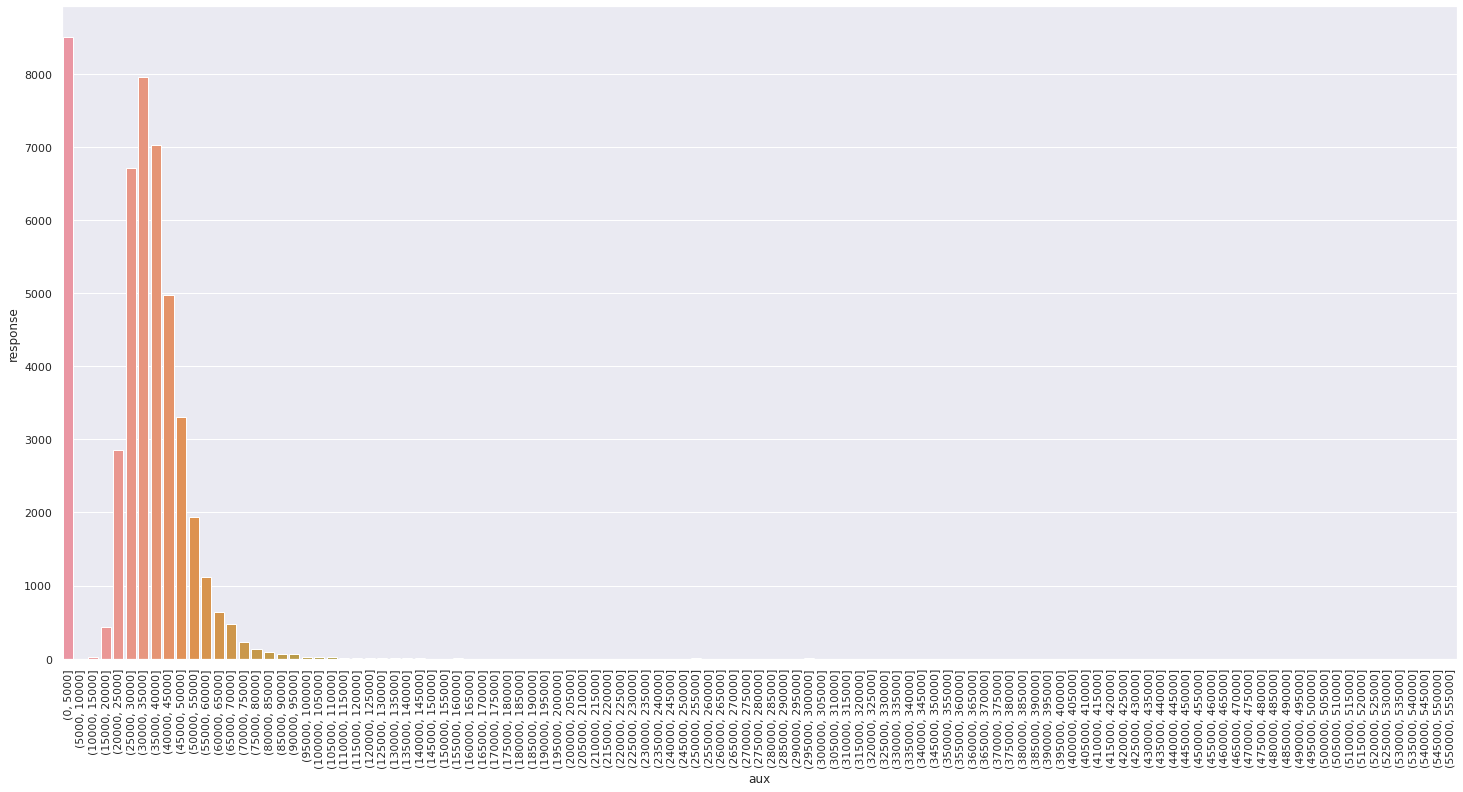

In [16]:
sns.barplot(x='aux',y='response',data=h5)
plt.xticks(rotation=90);

Falso, conforme aumenta a renda não aumentar o número des respostas positivas

False, the increse of annual expenses does not corresponde to any increse in car insurence contracts

### h6: clientes do sexo masculino tem mais probablidade de ter um carro danificado

**h6: Male customers are more likely to have previous car damage**

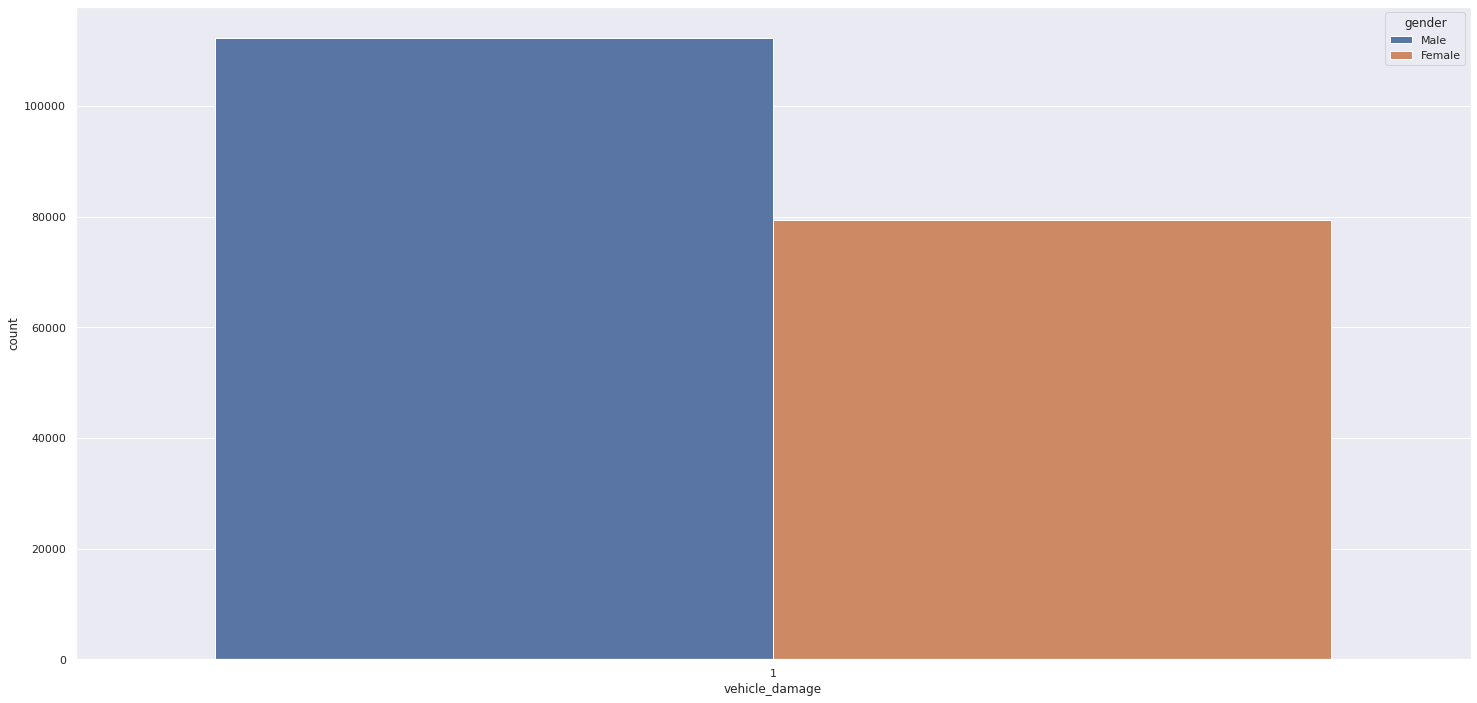

In [17]:
h6 = df4[['vehicle_damage','gender']]
sns.countplot(x='vehicle_damage',data=h6[h6['vehicle_damage']==1],hue='gender')

Verdadeiro, clientes do sexo masculino lideram na quantidade de carros danificados

True, male customers lead the car damage count

### h7: clientes do sexo feminino tem mais tendência a já ter seguro que do sexo masculinos

**h7: Female customers are more likely to have previous car insurance than male customers**

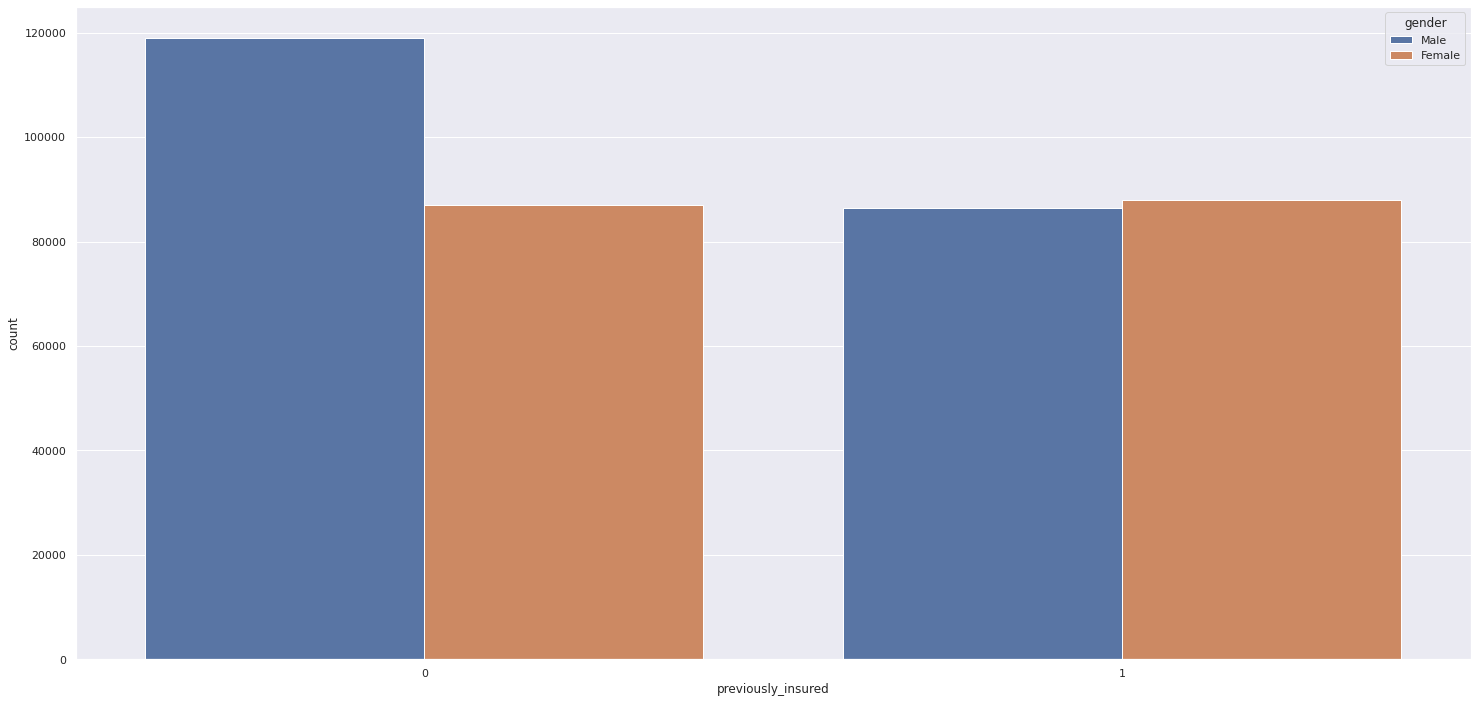

In [18]:
h7 = df4[['gender','previously_insured']]
sns.countplot(x='previously_insured',data=h7,hue='gender')

In [19]:
h7.groupby(['previously_insured','gender']).size()

previously_insured  gender
0                   Female     86923
                    Male      118987
1                   Female     87885
                    Male       86502
dtype: int64

verdadeiro, clientes feminias tem mais probabilidade de já ter seguro, mas a diferença é pouca

True, female customers are more likely to already have car insurance, but the difference is very small

### h8: clientes do sexo feminino tem 25% mais interrese em seguro do que do sexo masculino

**h8: Female customers are 25% more interest in car insurance than male customers**

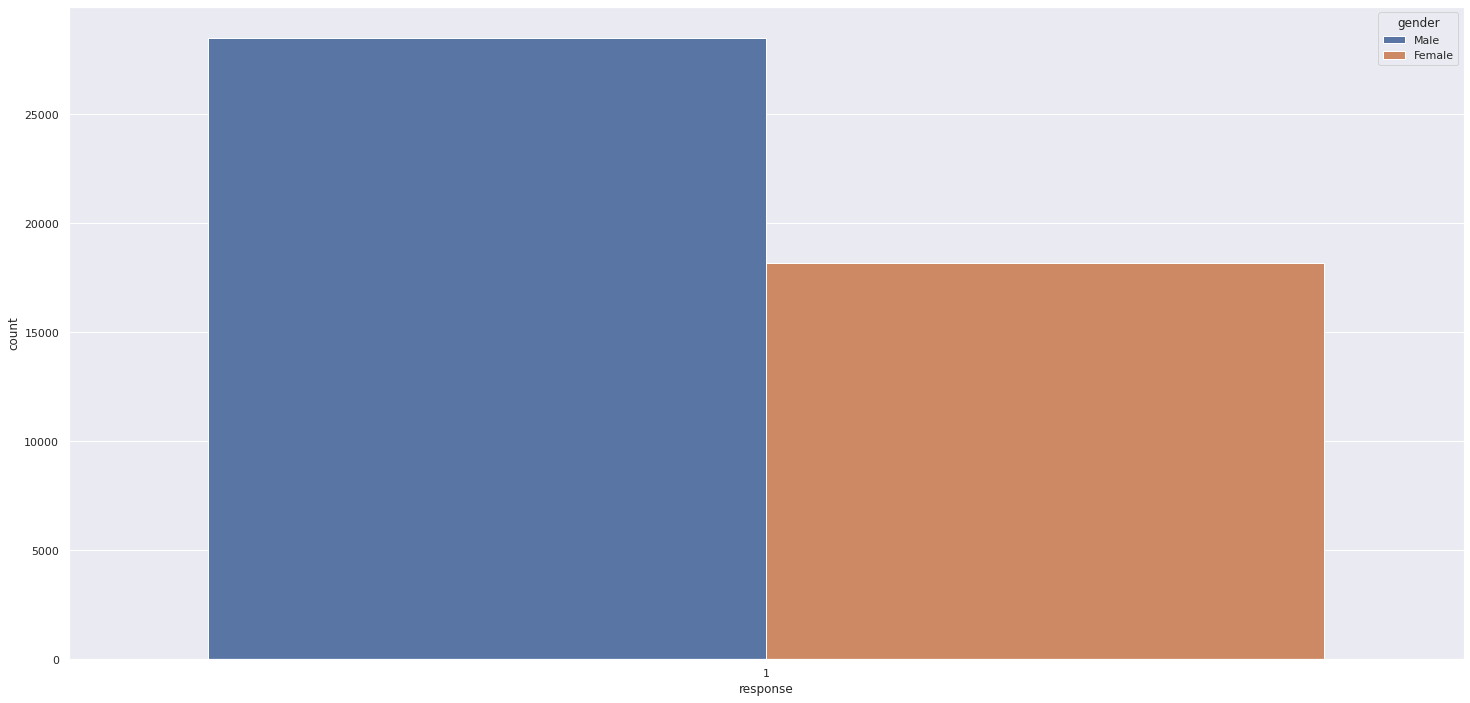

In [20]:
h8 = df4[['gender','response']]
sns.countplot(x='response',data=h8[h8['response']==1],hue='gender')

In [21]:
h8 = df4[['gender','response']]
h8 = h8.groupby(['response','gender']).size().reset_index()
h8 = h8[h8['response']==1]
h8['%'] = round(h8[0]/h8[0].sum(),2)
h8


,response,gender,0,%
2,1,Female,18171,0.39
3,1,Male,28498,0.61


Falso, dentre os que responderão afirmativo ao interresse no segundo seguro 61 % são do sexo masculino e 39% do feminino, sendo 22% de diferença

False, among the positive group 61% are male and 30% female, being 22% of difference

### h9: clientes com mais  de 180 dias na empresa tendem a aceitar a proposta de outro seguro

**h9: Customers with more than 180 days with the company are more likely to accept the insurance proposal**

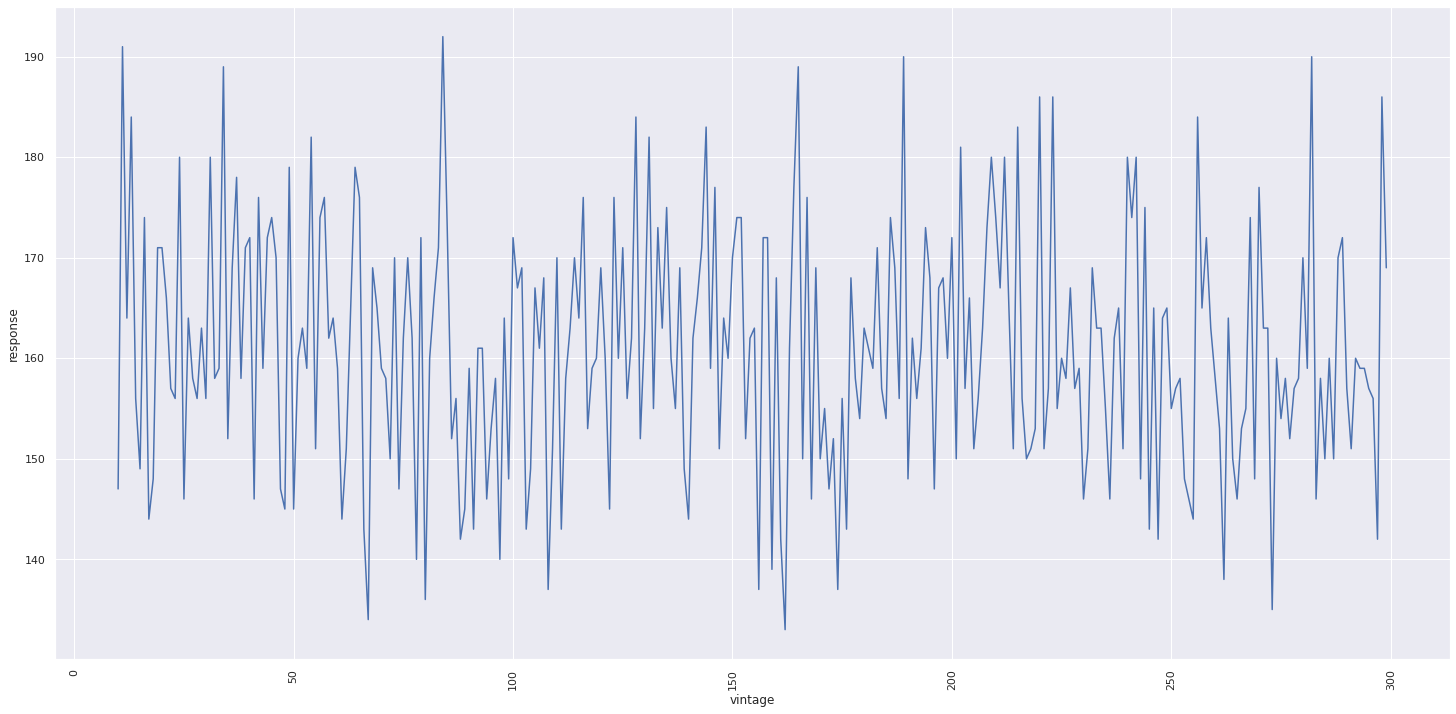

In [22]:
h9 = df4[['vintage','response']].groupby('vintage').sum().reset_index()
sns.lineplot(x='vintage',y='response',data=h9)
plt.xticks(rotation=90);

Falso, não há relação entre tempo do usuário como cliente da empresa e o fato dele desmonstrar menos ou mais interrese no segundo seguro

False, there is no relationship between the time of the customers with the company and the greater or lesser interest on the second insurance

### h10: Clientes a mais tempo na empresa gastam mais

**h10: Older costumers are more likely to spend more with the company**

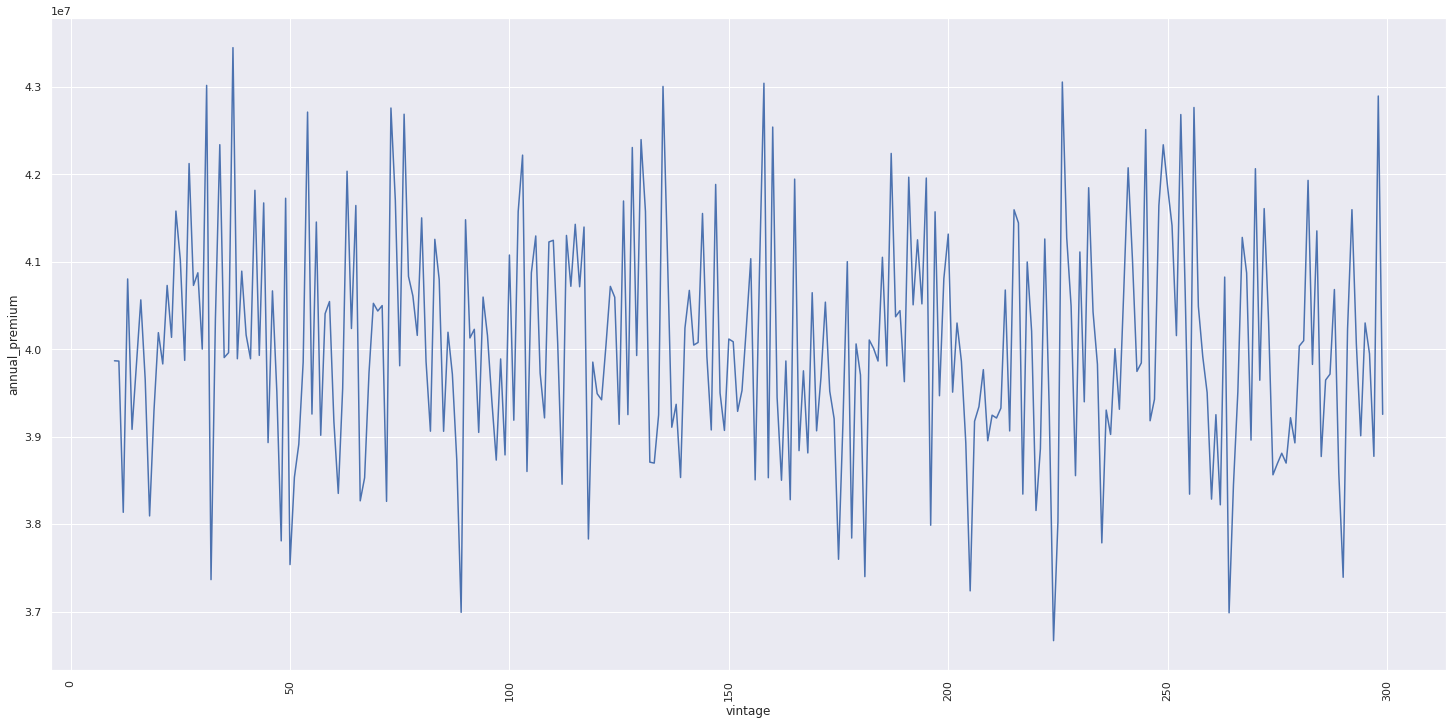

In [23]:
h10 = df4[['vintage','annual_premium']].groupby('vintage').sum().reset_index()
sns.lineplot(x='vintage',y='annual_premium',data=h10)
plt.xticks(rotation=90);

Falso, não há relação entre tempo do usuário como cliente da empresa e o gasto anual com seguro

False, there is no relationship between the time of the customers with the company and the greater or lesser annual spend

### h11: clientes com carros mais antigos ">2 years" tem mais danos

**h11: Customers with older cars "> 2 years" are more likely to have a damage**

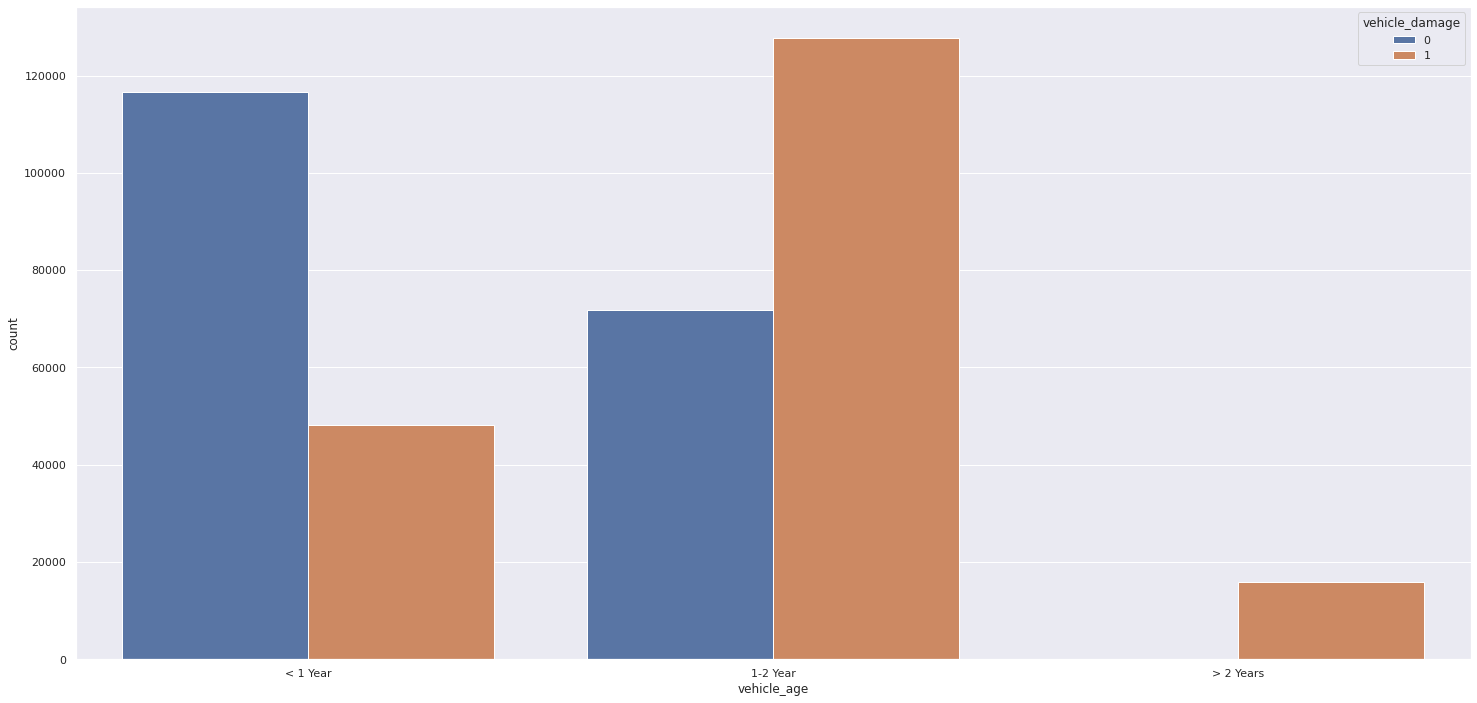

In [24]:
h11 = df4[['vehicle_age','vehicle_damage']]
sns.countplot(x='vehicle_age',data=h11,hue='vehicle_damage',order=['< 1 Year','1-2 Year','> 2 Years'])

In [25]:
h11.groupby(['vehicle_age','vehicle_damage']).size().reset_index()

,vehicle_age,vehicle_damage,0
0,1-2 Year,0,71835
1,1-2 Year,1,127726
2,< 1 Year,0,116590
3,< 1 Year,1,48195
4,> 2 Years,0,15
5,> 2 Years,1,15936


Verdadeiro, poucos clientes com carros acima de 2 anos de uso não tem um dano no veiculo, e como pode-se notar provavelmente pela própria utilização a proporção de carros danificados aumenta conforme a idade do carro

True, only a few costumers with car older than 2 years has no damage in the vehicle, and as one can probably notice the proportion of damaged vehicles grows with the age of the car

### h12: clientes com carros mais novos "<2year" contratam mais seguro

**h12: Customers with newer cars "< 2 year" are more interested in car insurance than with older ones**

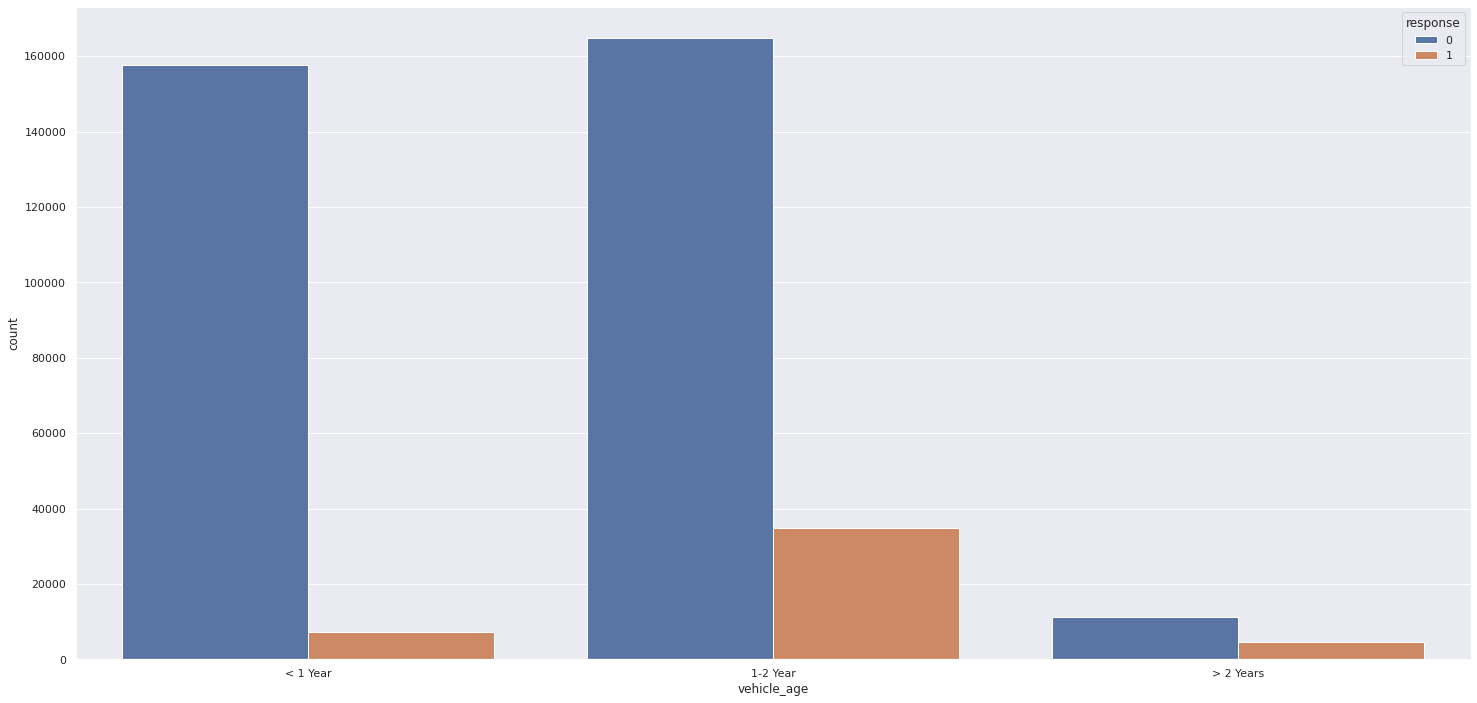

In [26]:
h12 = df4[['vehicle_age','response']]
sns.countplot(x='vehicle_age',data=h12,hue='response',order=['< 1 Year','1-2 Year','> 2 Years'])

In [27]:
h12_aux1 = h12.groupby(['vehicle_age']).size().reset_index()

In [28]:
h12_aux2 = h12.groupby(['vehicle_age','response']).size().reset_index()

In [29]:
h12_aux3 =h12_aux2.merge(h12_aux1,how='left',on='vehicle_age')

In [30]:
h12_aux3['response_%'] = h12_aux3['0_x']/h12_aux3['0_y']
h12_aux3 

,vehicle_age,response,0_x,0_y,response_%
0,1-2 Year,0,164791,199561,0.825768
1,1-2 Year,1,34770,199561,0.174232
2,< 1 Year,0,157583,164785,0.956295
3,< 1 Year,1,7202,164785,0.043705
4,> 2 Years,0,11254,15951,0.705536
5,> 2 Years,1,4697,15951,0.294464


Falso, proporcionalmente clientes com carros com mais de 2 anos de uso contratam mais o segundo seguro

False, proportionally, customers with vehicles older than 2 years contract the second insurance more

### h13: clientes com carros já danificados contratam seguro 3x mais

**h13: Customers with previous car damage take out 3 times more insurance**


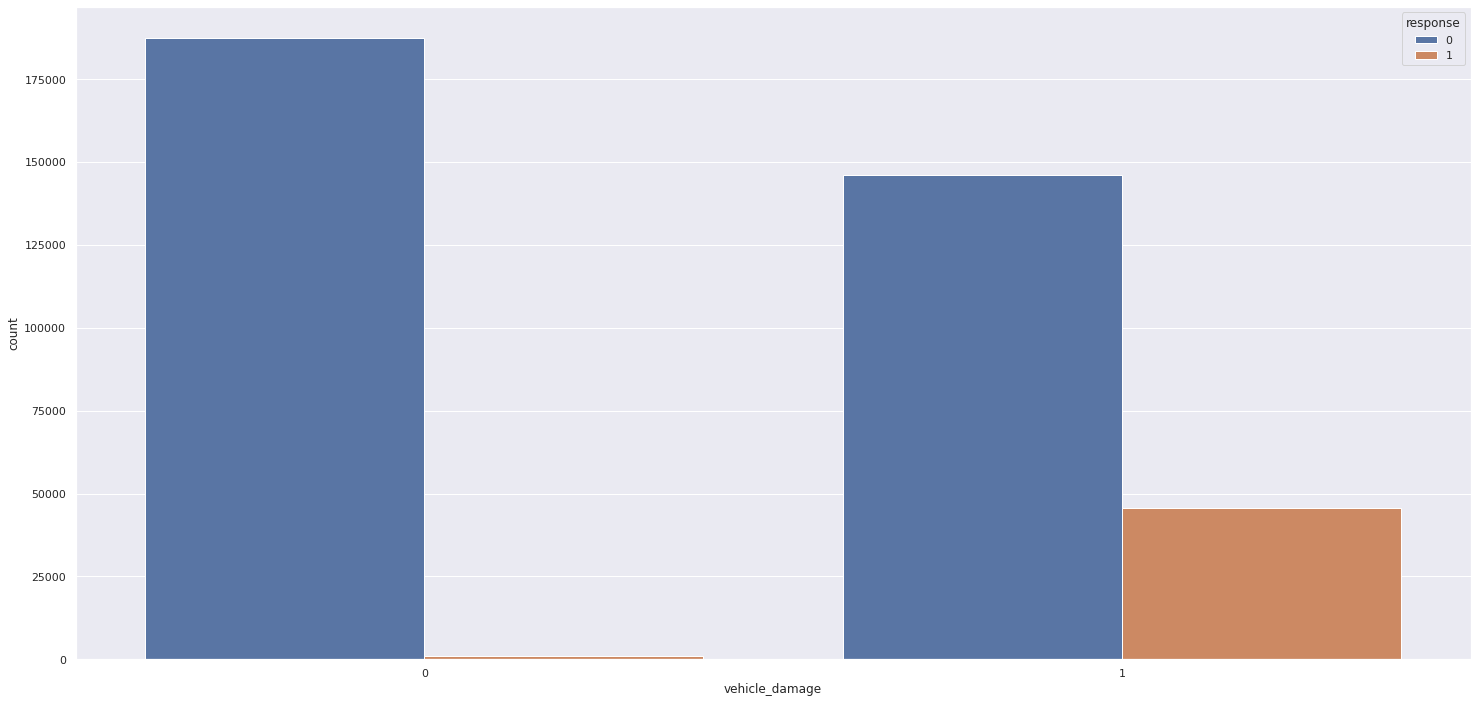

In [31]:
h13 = df4[['vehicle_damage','response']]
sns.countplot(x='vehicle_damage',data=h13,hue='response')

In [32]:
h13.groupby(['vehicle_damage','response']).size().reset_index()

,vehicle_damage,response,0
0,0,0,187458
1,0,1,982
2,1,0,146170
3,1,1,45687


Falso, clientes que sofreram algum dano no carro contratam um seguro até 47 vezes mais, superando a expectativa de apenas 3 vezes mais

False, customers who have suffered vehicle damage are more likely to contract a car insurance 47 times more, suparsing the expectations of just 3 times

## Multivariate analysis

### Numerical atributes x Numerical atributes

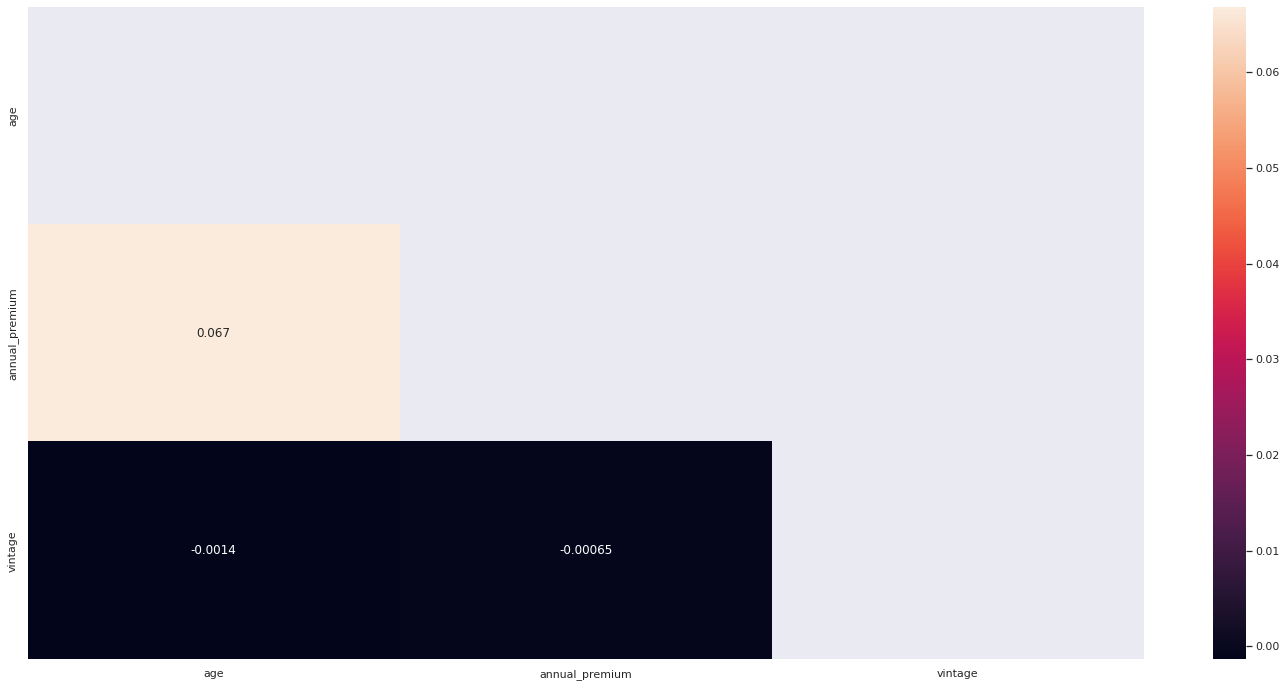

In [33]:
num_atributtes = df4[['age','annual_premium', 'vintage']]
correlation = num_atributtes.corr(method='pearson')
matrix = np.triu(correlation)
sns.heatmap(correlation,annot=True,mask=matrix)

### Numerical atributes x categorical atribute

In [34]:
import scipy.stats as stats

In [35]:
stats.pointbiserialr(df4['response'],num_atributtes['age'])

PointbiserialrResult(correlation=0.11256797731738578, pvalue=0.0)

In [36]:
stats.pointbiserialr(df4['response'],num_atributtes['annual_premium'])

PointbiserialrResult(correlation=0.022778787143168285, pvalue=7.807402592534752e-45)

In [37]:
stats.pointbiserialr(df4['response'],num_atributtes['vintage'])

PointbiserialrResult(correlation=-0.0009961610538163199, pvalue=0.5390085302083055)

### Categorical atributes x Categorical atributes

In [38]:
cat_atributtes = df4[['gender','policy_sales_channel','region_code','previously_insured','vehicle_damage','vehicle_age','response']]

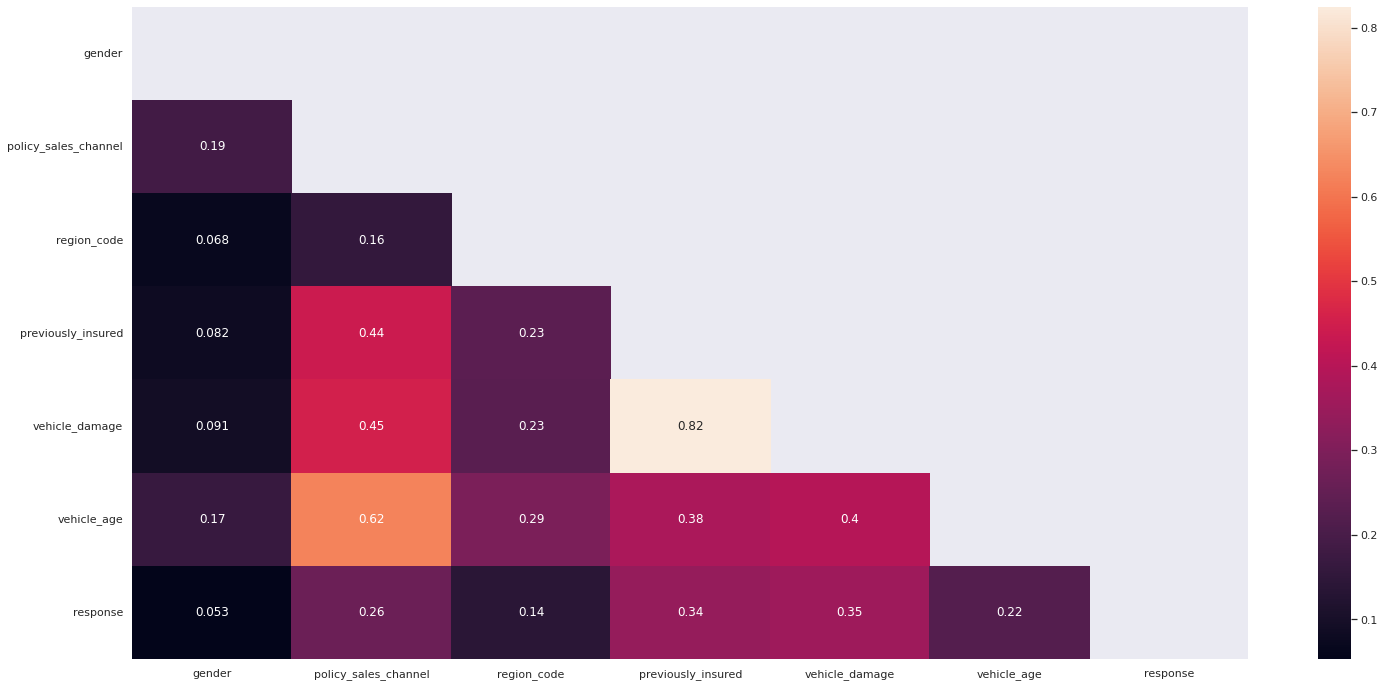

In [39]:

cat_list = ['gender','policy_sales_channel','region_code','previously_insured','vehicle_damage','vehicle_age','response']
cat_dic = {}


for c1 in cat_list:
    for c2 in cat_list:
        v = cramer_v(cat_atributtes[c1], cat_atributtes[c2])

        if cat_list.index(c2) == 0:
            cat_dic[c1] = []
            cat_dic[c1].append(v)

        else:
            cat_dic[c1].append(v)


cramer_v_table = pd.DataFrame(cat_dic)
cramer_v_table.set_index(cramer_v_table.columns, inplace=True)

matrix = np.triu(cramer_v_table)
sns.heatmap(cramer_v_table, annot=True,mask=matrix)

In [40]:
aux = cramer_v_table.iloc[-1].reset_index()
aux['corr_method'] = 'Cramer_v'
aux.columns = ['feature', 'response', 'corr_method']

In [41]:
aux = aux.append(dict(zip(aux.columns,["age",stats.pointbiserialr(df4['response'],num_atributtes['age'])[0],"Point_bisseral"])),ignore_index=True)
aux = aux.append(dict(zip(aux.columns,["annual_premium",stats.pointbiserialr(df4['response'],num_atributtes['annual_premium'])[0],"Point_bisseral"])),ignore_index=True)
aux = aux.append(dict(zip(aux.columns,["vintage",stats.pointbiserialr(df4['response'],num_atributtes['vintage'])[0],"Point_bisseral"])),ignore_index=True)

In [42]:
correlation = aux.sort_values(by='response',ascending=False)

In [43]:
correlation

,feature,response,corr_method
6,response,0.999989,Cramer_v
4,vehicle_damage,0.354916,Cramer_v
3,previously_insured,0.341644,Cramer_v
1,policy_sales_channel,0.264084,Cramer_v
5,vehicle_age,0.222608,Cramer_v
2,region_code,0.138500,Cramer_v
7,age,0.112568,Point_bisseral
0,gender,0.052752,Cramer_v
8,annual_premium,0.022779,Point_bisseral
9,vintage,-0.000996,Point_bisseral


**A lista final das correlações em relação a variavel resposta nos da uma boa noção de quais atributos podem ter um grande peso pra o modelo**

**The final correlation list, shows which atributtes may have great weight for the model**